In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset extraction

In [ ]:
import torch 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib as plt
from tqdm import tqdm
from joblib import dump, load
import sys
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

dumps_path = '/content/drive/MyDrive/Colab Notebooks/progetto_manutenzione/dumps'
base_path = '/content/drive/MyDrive/Colab Notebooks/progetto_manutenzione/dataset/'
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"



In [ ]:
dumps_path = '/content/drive/MyDrive/progetto_manutenzione/dumps/'
base_path = '/content/drive/MyDrive/progetto_manutenzione/dataset/'

## Extraction
Insert the entire dataset in the list dfs.
Every element in the list is a df containing the dataset in a file.

In [ ]:
import h5py

def extract_df(path: str, train: bool):
  with h5py.File(path, 'r') as hdf:
    if(train == True):
      W = np.array(hdf.get('W_dev'))             # W
      X_s = np.array(hdf.get('X_s_dev'))         # X_s
      Y = np.array(hdf.get('Y_dev'))             # RUL
      A = np.array(hdf.get('A_dev'))             # Auxiliary
    else:
      W = np.array(hdf.get('W_test'))            # W
      X_s = np.array(hdf.get('X_s_test'))        # X_s
      Y = np.array(hdf.get('Y_test'))             # RUL
      A = np.array(hdf.get('A_test'))             # Auxiliary

    W_var = np.array(hdf.get('W_var'))
    X_s_var = np.array(hdf.get('X_s_var'))  
    A_var = np.array(hdf.get('A_var'))
    
    # from np.array to list dtype U4/U5
    W_var = list(np.array(W_var, dtype='U20'))
    X_s_var = list(np.array(X_s_var, dtype='U20'))  
    A_var = list(np.array(A_var, dtype='U20'))

    df_Y = pd.DataFrame(Y, columns=['RUL'])
    df_X = pd.DataFrame(X_s, columns=X_s_var)
    df_W = pd.DataFrame(W, columns=W_var)
    df_A = pd.DataFrame(A, columns=A_var)

    return pd.concat([df_Y, df_W, df_A, df_X], axis=1)

def find_begin_RTF_indexes(df):
  index_list = [0]
  index = 0
  for i in df.cycle.diff():
    if i < 0:
      index_list.append(index+1)
    index += 1
  return index_list

def find_begin_ts_indexes(cruise_df):
  begin_indexes = [0]
  indexes_diff = pd.Series(cruise_df.index).diff()
  i = 0
  for v in indexes_diff:
    if v > 1: 
      begin_indexes.append(i)
    i+=1
  return begin_indexes

def find_begin_cycle_indexes(df):
  index_list = [0]
  index = 0
  for i in df.cycle.diff():
    if i > 0:
      index_list.append(index)
    index += 1
  return index_list

def get_cycle_list(dfs):
  dfs_final = []
  for df in dfs:
    idxs = find_begin_cycle_indexes(df)
    for i in range(0,len(idxs)-1):
      start_idx = idxs[i]
      end_idx = idxs[i+1]
      local_df = pd.DataFrame(df.iloc[start_idx:end_idx])
      dfs_final.append(local_df)
    local_df = pd.DataFrame(df.iloc[idxs[-1]:])
    dfs_final.append(local_df)
  return dfs_final

def filter_cruise_alt(df, delta, meanV, secCruise):
  # Returns a boolean array of the same lenght of alt.
  # True value in position i means that in that moment the airplane was
  # cruising for at least 95% of the previous secCruise seconds.
  local_df = pd.DataFrame(df.alt.copy())
  local_df['cruise'] = False
  local_df['parCruise'] = False
  # using a moving mean on delta seconds
  local_df['meanAlt'] = local_df.alt.rolling(delta).mean()
  local_df['meanAltDiff'] = local_df.meanAlt.diff()

  for i in range(secCruise+1, len(df)):
    if abs(local_df.meanAltDiff.iloc[i]) < meanV:
        local_df.parCruise.iat[i] = True
        if local_df.parCruise.iloc[i-secCruise:i].mean() > 0.95:
            local_df.cruise.iat[i] = True
  return df[local_df.cruise]


def filter_cruise_list(dfs: list, delta: int, meanV: int, secCruise: int):
  """
  Takes the dfs list and returns a new dfs list with dataframe element in which values are filtered on the cruising 
  altitude.
  Parameters
  ---
  dfs : the dfs list
  delta : how many seconds the altitude gets mediated before looking at the altitude variation
  meanV : max mean variation accepted on the delta seconds before
  secCruise : at least 95% of secCruise consecutive seconds an altitude needs to be stable before considering it
    cruising.
  """
  
  final_dfs = []
  for df in tqdm(dfs):
    final_dfs.append(filter_cruise_alt(df[df.alt>10000], delta, meanV, secCruise))
  return final_dfs

def add_cond_features(dfs):
  new_dfs = []
  for df in dfs:
    new_df = df.copy()
    new_df['alt_diff'] = df.alt.diff()
    new_df['Mach_diff'] = df.Mach.diff()
    new_df['TRA_diff'] = df.TRA.diff()
    new_df['T2_diff'] = df.T2.diff()
    new_dfs.append(new_df)
  return new_dfs

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/progetto_manutenzione/dataset/'
#filenames = ["N-CMAPSS_DS01-005.h5", "N-CMAPSS_DS02-006.h5", "N-CMAPSS_DS03-012.h5", "N-CMAPSS_DS04.h5", "N-CMAPSS_DS05.h5", "N-CMAPSS_DS06.h5", "N-CMAPSS_DS07.h5", "N-CMAPSS_DS08a-009.h5", "N-CMAPSS_DS08c-008.h5"];
filenames = ["N-CMAPSS_DS01-005.h5" , "N-CMAPSS_DS02-006.h5", "N-CMAPSS_DS05.h5"]

# dfs is a list containing the tables for each file of the dataset
dfs = list()
for filename in tqdm(filenames):
  path = base_path + filename
  local_df = extract_df(path, train=True)
  dfs.append(local_df.iloc[::])

## Cruising filtering

In [ ]:
cycle_sampling_rate = 1

# dfs_sep the list of tables each containing a cycle
# dfs_cruise is the list of tables each containing a filtered cycle on the altitude
dfs_sep = get_cycle_list(dfs)
dfs_sep = add_cond_features(dfs_sep)
dfs_cruise = filter_cruise_list(dfs_sep[0::cycle_sampling_rate], 30, 2, 60)

# Standardization and PCA
FOR CONDITION
(for data will be done inside the RNN model)

In [ ]:
from sklearn import preprocessing, decomposition

# random state for reproducibility
rs = 1

# remove and saving label from training data
x_train = pd.concat(dfs_cruise)
y_train = x_train.pop('RUL')

# extract conditions
condition = x_train[['alt', 'Mach', 'TRA', 'T2',
                     'alt_diff', 'Mach_diff', 'TRA_diff', 'T2_diff', 'hs', 'cycle']]

# condition = x_train[['cycle', 'Nf', 'Nc', 'Wf']]
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
condition = condition.to_numpy()

# scaler and pca object for condition
cond_scaler = preprocessing.StandardScaler().fit(condition)
cond_pca = decomposition.PCA(n_components=0.95, random_state=rs).fit(condition)


condition_transformed = cond_pca.transform(cond_scaler.transform(condition))
condition_transformed

# Clustering

In [ ]:
from sklearn.cluster import KMeans
rs = 1
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=rs).fit(condition_transformed)
cluster_result = kmeans.predict(condition_transformed)

## Evaluation and selection

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

range_n_clusters = [3, 4, 5, 6, 7]
# sampling rate for silhouette evauation 
clustering_sampling_rate = 10

def silhouette_score_visualizer(dataset, n_cluster):
  # Instantiate the clustering model and visualizer
  visualizer = SilhouetteVisualizer(KMeans(n_clusters = n_cluster, max_iter = 300, random_state = rs),colors='yellowbrick')

  plt.figure(figsize=(15,8))
  #print(x_3d.drop("pred",axis=1))
  visualizer.fit(dataset)        # Fit the data to the visualizer
  visualizer.show()        # Finalize and render the figure

for n_cluster in range_n_clusters:
  print(f'loading silhouette with {n_cluster} cluster')
  silhouette_score_visualizer(condition_transformed[0::clustering_sampling_rate], n_cluster)

We select Kmeans with **3** clusters

## Visualization

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=rs).fit(condition_transformed)

cluster_result = kmeans.predict(condition_transformed)

res = pd.concat(dfs_cruise).reset_index(drop = True)
res['cluster'] = cluster_result
res = res[0::100]

In [ ]:
for col in res.columns:
  plt.figure()
  sns.scatterplot(x = res.cycle, y = res[col], hue = res.cluster)

# RNN model training

The following class defines methods and attributes to pre-process each flight inside each run-to-failure profile.

In [ ]:
kmeans = load(dumps_path+'/kmeans')
cond_scaler = load(dumps_path+'/cond_scaler')
cond_pca = load(dumps_path+'/cond_pca')

class Cycle:
  def __init__(self):
    self.cycle = pd.DataFrame()
    self.cruise = pd.DataFrame()
    self.condition = pd.DataFrame()
    self.cluster_point_list = [[]]
    self.rul_est_list = [[]]
    self.final_rul = int()
    self.cluster = []
  
  def transform_condition(self, pca_model, scaler_model):
    self.condition = self.condition.to_numpy()
    self.condition = pca_model.transform(scaler_model.transform(self.condition))
  
  def predict_cluster(self, kmeans_model):
    self.cluster

  def create_cluster_list(self, n_cluster, train=True):
    cluster_list = [[] for x in range(n_cluster)]
    begin_ts_indexes = find_begin_ts_indexes(self.cruise)
    if len(begin_ts_indexes) > 1:
      for i in range(0, len(begin_ts_indexes)-1):
        start_id = begin_ts_indexes[i]
        end_id = begin_ts_indexes[i+1]
        cluster = self.cruise.cluster.iloc[start_id:end_id].value_counts().idxmax()
        cluster_list[cluster].append([start_id, end_id])
    start_id = begin_ts_indexes[-1]
    end_id = len(self.cruise)
   # print(end_id)
    cluster = self.cruise.cluster.iloc[start_id:end_id].value_counts().idxmax()
    cluster_list[cluster].append([start_id, end_id])
    self.cluster_index_list = cluster_list
    
    if train:
      self.cycle = None
      self.condition = None

  @property
  def cluster_list(self):
    cluster_list = []
    for c in self.cluster_index_list:
      cluster_list.append([self.cruise.iloc[s:e] for [s,e] in c])
    return cluster_list

We're going to upload all h5 files.

In [ ]:
filenames = ["N-CMAPSS_DS01-005.h5", "N-CMAPSS_DS02-006.h5", "N-CMAPSS_DS03-012.h5", "N-CMAPSS_DS04.h5", "N-CMAPSS_DS05.h5", "N-CMAPSS_DS06.h5", "N-CMAPSS_DS07.h5", "N-CMAPSS_DS08a-009.h5", "N-CMAPSS_DS08c-008.h5"];
#filenames = ["N-CMAPSS_DS01-005.h5"]
dfs = list()
for filename in tqdm(filenames):
  path = base_path + filename
  local_df = extract_df(path, train=True)
  dfs.append(local_df)

dfs_sep = get_cycle_list(dfs)

In [ ]:
cycle_sampling_rate = 1
cycle_list = [Cycle() for n in range(0, len(dfs_sep), cycle_sampling_rate)]
for n in tqdm(range(0, len(cycle_list))):
  local_cycle = cycle_list[n]
  local_cycle.cycle = add_cond_features([dfs_sep[n]])[0]
  local_cycle.cruise = filter_cruise_alt(local_cycle.cycle, 30, 2, 60)
  local_cycle.condition = local_cycle.cruise[['alt', 'Mach', 'TRA', 'T2',
                     'alt_diff', 'Mach_diff', 'TRA_diff', 'T2_diff', 'hs', 'cycle']]
  local_cycle.transform_condition(cond_pca, cond_scaler)
  local_cycle.cruise.insert(loc = 0, column='cluster', value=kmeans.predict(local_cycle.condition))
  local_cycle.create_cluster_list(kmeans.n_clusters)

import pickle

# save the list of objects
with open(dumps_path + 'cycle_list.pickle', 'wb') as f:
    pickle.dump(cycle_list, f)


## LOAD CYCLE LIST

We can import the previous processed cycle_list

In [ ]:
# reload the list of cycles
with open(dumps_path + 'cycle_list.pickle', 'rb') as f:
    cycle_list = pickle.load(f)

Example for printing the stable cruise of the airplane

## MINMAX

Now we need to build tensors to be used for training. 

In [ ]:
list_drop_columns = ['RUL','cluster']

def str_columns(df):
 for col in df.columns:
    df.rename(columns={col: str(col)}, inplace=True)

We're going to fit the MinMaxScaler for each cluster we defined.

In [ ]:
final_lists=[[] for x in range(kmeans.n_clusters)]
min_max_scalers=[MinMaxScaler() for x in range(kmeans.n_clusters)]

for i in range (len(cycle_list)):
   all_list_df = cycle_list[i].cluster_list
   for j in range(len(all_list_df)):
    single_list_df = cycle_list[i].cluster_list[j]
    for single_df in single_list_df:
      
        cluster = j
        

        final_lists[cluster].append(single_df)

# concatenate all the rows for each cluster
# fit then the MinMaxScaler 
for j in range(len(final_lists)):
   final_lists[j] = pd.concat(final_lists[j], axis=0, ignore_index=True).drop(columns=list_drop_columns)
   str_columns(final_lists[j])
   min_max_scalers[j] = min_max_scalers[j].fit(final_lists[j])

# save the list of MinMaxScalers
with open(dumps_path + 'minmaxscalers.pickle', 'wb') as f:
    pickle.dump(min_max_scalers, f)
  

## LOAD MINMAXSCALER(s)

We can import the fitted MinMaxScalers from local storage

In [ ]:
# reload the list of MinMaxScalers
with open(dumps_path + 'minmaxscalers.pickle', 'rb') as f:
    min_max_scalers = pickle.load(f)

#print(min_max_scalers[0].scale_)
#print(min_max_scalers[1].scale_)
#print(min_max_scalers[2].scale_)

## CREATING TENSORS FROM DATAFRAMES

We're going to create a list of tensors and targets, for each cluster, for each time series.
In this way, we'll have, for each cluster, a list of ready normalized data , with the relative RUL, that will be used to train 3 different CNNs using PyTorch

In [ ]:
def get_cluster_time_series(c_list):
  all_tensors=[[] for x in range(kmeans.n_clusters)]
  all_targets=[[] for x in range(kmeans.n_clusters)]

  # get all cycles
  for i in range (len(c_list)):
    all_list_df = c_list[i].cluster_list

    # get all time series for each cluster of the specific cycle
    for j in range(len(all_list_df)):
      single_list_df = c_list[i].cluster_list[j]

      # get the single time series 
      for single_df in single_list_df:

          rul = single_df.iloc[0].RUL
          
          cluster = j

          # save the rul for this time series
          all_targets[cluster].append(rul)

          new_df = single_df.drop(columns=list_drop_columns)
          str_columns(new_df)

          # normalize data using the MinMaxScaler of cluster j
          new_df = min_max_scalers[cluster].transform(new_df)
      
          # create the float tensor that will be used to train the CNN
          tensor = torch.from_numpy(new_df).float().permute(1,0)
          
          # save the tensor
          all_tensors[cluster].append(tensor)

  return all_tensors, all_targets



In [ ]:
all_tensors, all_targets = get_cluster_time_series(cycle_list)

# we'll have many list of tensors, one for each cluster
# save the list of tensors on storage
with open(dumps_path + 'training_tensors.pickle', 'wb') as f:
    pickle.dump([all_tensors, all_targets], f)

## LOAD TRAINING DATA

We can import the tensors for training from the storage

In [ ]:
# reload the list of training data tensors
with open(dumps_path + 'training_tensors.pickle', 'rb') as f:
    training_data = pickle.load(f)

all_tensors = training_data[0]
all_targets = training_data[1]

print(len(all_tensors[1]), len(all_targets[1]))
print(len(all_tensors[2]), len(all_targets[2]))
print(len(all_tensors[0]), len(all_targets[0]))

print(all_tensors[0][0][:5])

11788 11788
4984 4984
3078 3078
tensor([[0.5649, 0.5650, 0.5650,  ..., 0.5584, 0.5580, 0.5576],
        [0.4071, 0.4087, 0.4075,  ..., 0.7850, 0.7846, 0.7846],
        [0.9074, 0.9074, 0.9074,  ..., 0.8270, 0.8225, 0.8164],
        [0.4338, 0.4343, 0.4339,  ..., 0.5716, 0.5718, 0.5720],
        [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526]])


# LOAD VALIDATION DATA

In [ ]:
kmeans = load(dumps_path+'/kmeans')
cond_scaler = load(dumps_path+'/cond_scaler')
cond_pca = load(dumps_path+'/cond_pca')

We're going to load h5 files for validation 

In [ ]:
def get_val_h5(filenames):
    test_filenames = filenames

    dfs_test = list()
    for filename in tqdm(test_filenames):
      path = base_path + filename
      local_df = extract_df(path, train=False)
      dfs_test.append(local_df)

    return get_cycle_list(dfs_test)

dfs_val_sep = get_val_h5(["N-CMAPSS_DS01-005.h5", "N-CMAPSS_DS02-006.h5", "N-CMAPSS_DS03-012.h5", "N-CMAPSS_DS04.h5", "N-CMAPSS_DS05.h5", "N-CMAPSS_DS06.h5", "N-CMAPSS_DS07.h5", "N-CMAPSS_DS08a-009.h5", "N-CMAPSS_DS08c-008.h5"])

100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


Creates, for each flight (cycle) of each run-to-failure profile, the Cycle() object

In [ ]:
def get_val_cycle_list(dfs_test_sep, filename):
  # defines how many cycles will be skipped each time
  # 1 means it takes all the cycles
  test_sampling_rate = 1 
  cycle_test_list = [Cycle() for n in range(0, len(dfs_test_sep), test_sampling_rate)]
  for n in tqdm(range(0, len(cycle_test_list))):
    local_cycle = cycle_test_list[n]
    local_cycle.cycle = add_cond_features([dfs_test_sep[n]])[0]
    local_cycle.cruise = filter_cruise_alt(local_cycle.cycle, 30, 2, 60)
    
    if len(local_cycle.cruise) == 0:
      print()
      non_missing_df = local_cycle.cycle.dropna()
      local_cycle.cruise = non_missing_df[non_missing_df['alt'] >= 10000]
      print("found empty local_cycle.cruise")
      print("taking only flights above 10.000 feets")

    local_cycle.condition = local_cycle.cruise[['alt', 'Mach', 'TRA', 'T2',
                      'alt_diff', 'Mach_diff', 'TRA_diff', 'T2_diff', 'hs', 'cycle']]
    local_cycle.transform_condition(cond_pca, cond_scaler)
    local_cycle.cruise.insert(loc = 0, column='cluster', value=kmeans.predict(local_cycle.condition))
    local_cycle.create_cluster_list(kmeans.n_clusters, train=False)

  # save the list of objects
  with open(dumps_path + filename, 'wb') as f:
      pickle.dump(cycle_test_list, f)
  
  return cycle_test_list

cycle_val_list = get_val_cycle_list(dfs_val_sep, 'cycle_val_list.pickle')

 14%|█▍        | 400/2908 [08:32<39:42,  1.05it/s]


found empty local_cycle.cruise
taking only flights above 10.000 feets


 14%|█▍        | 407/2908 [08:35<23:00,  1.81it/s]


found empty local_cycle.cruise
taking only flights above 10.000 feets


 14%|█▍        | 412/2908 [08:36<13:39,  3.05it/s]


found empty local_cycle.cruise
taking only flights above 10.000 feets


 14%|█▍        | 420/2908 [08:40<15:51,  2.61it/s]


found empty local_cycle.cruise
taking only flights above 10.000 feets


 15%|█▌        | 447/2908 [08:51<09:57,  4.12it/s]


found empty local_cycle.cruise
taking only flights above 10.000 feets

found empty local_cycle.cruise
taking only flights above 10.000 feets


100%|██████████| 2908/2908 [1:00:49<00:00,  1.25s/it]


## CREATE VAL TENSORS
It creates the tensors for validation, with their RULs (targets), and save them locally.

In [ ]:
all_val_tensors, all_val_targets = get_cluster_time_series(cycle_val_list)

# save the list of objects
with open(dumps_path + 'validation_tensors.pickle', 'wb') as f:
    pickle.dump([all_val_tensors, all_val_targets], f)

## LOAD VAL CYCLE LIST

We can reload the Cycle() list of objects for each flight

In [ ]:
# reload the list of cycles
with open(dumps_path + 'cycle_val_list.pickle', 'rb') as f:
    cycle_val_list = pickle.load(f)

In [ ]:
cycle_val_list[0].cycle.columns

Index(['RUL', 'alt', 'Mach', 'TRA', 'T2', 'unit', 'cycle', 'Fc', 'hs', 'T24',
       'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50',
       'Nf', 'Nc', 'Wf', 'alt_diff', 'Mach_diff', 'TRA_diff', 'T2_diff'],
      dtype='object')

In [ ]:
cycle_val_list[0].cruise.columns

Index(['cluster', 'RUL', 'alt', 'Mach', 'TRA', 'T2', 'unit', 'cycle', 'Fc',
       'hs', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30',
       'P40', 'P50', 'Nf', 'Nc', 'Wf', 'alt_diff', 'Mach_diff', 'TRA_diff',
       'T2_diff'],
      dtype='object')

## LOAD VAL TENSORS

We can reload the validation tensors (and targets)

In [ ]:
# reload the list of training data
with open(dumps_path + 'validation_tensors.pickle', 'rb') as f:
    val_data = pickle.load(f)

all_val_tensors = val_data[0]
all_val_targets = val_data[1]

In [ ]:
print(len(all_val_tensors[0]))
print(len(all_val_tensors[1]))
print(len(all_val_tensors[2]))

1629
7659
2471


# TRAINING AND TESTING

## BATCHES

In [ ]:
import random
import math
import os

The following function tries to make the training deterministic for a specific GPU, but we'll not use it

In [ ]:
def seed_everything(seed=1234):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"
    torch.use_deterministic_algorithms(True)


The following functions will define how to create the batches for training and/or validation. 

For the creation of batches, we first order all the time series provided by decreasing length (duration in seconds). In this way, if the batch has a size of 32, we try to include all time series of similar length inside the batch.
However, it may happen that a time series in the batch is longer than all the others. In this case, we make the other time series in the batch as long as the last one, thus uniforming the lengths. To make a time series longer by x seconds, we use zero-padding, i.e. we add x zeros at the beginning of the time sequence, for each feature.

After this, within that batch, if all the time series of uniform length are longer than a certain window time y expressed in seconds, each one will be divided into sub-time series of duration y seconds. For example, if a time series has a length of 3000 seconds and the time window is 1000 seconds, then it will be divided into 3 time series of 1000 seconds each.
Due to this, the size of the batch can increase beyond the "batch_size" limit, so new batches will be generated with the time series thus created.
For example, if we had a batch of size 16, and all the time series were 3000 seconds long, dividing each into 3 sub-time series of 1000 seconds, we would have 16*3 = 48 time series in the single batch. Then, every 16 time series, a new batch will be created. Therefore, instead of a single batch of 16, in the end we will have 3 batches of 16.

In [ ]:

# define how to do the zero-padding
# adds zeros at the beginning of the tensor to increase the lenght of all its features
# min_val is the minimum length in seconds that the time series must have
# max_val is the max length in seconds that the time series must have
def pad_tensor(tensor, min_val=10, max_val=None):
  shape_1 = tensor.shape[1]
  shape_0 = tensor.shape[0]
  old_values = tensor[:,0].unsqueeze(1)
  if max_val == None:
    if shape_1 < min_val:
      return torch.cat([torch.ones(shape_0, min_val - shape_1) * 0, tensor], dim=1)
  else:
    if max_val < min_val:
      max_val=min_val
    
    if shape_1 < max_val:
      
      return torch.cat([torch.ones(shape_0, max_val - shape_1) * 0, tensor], dim=1)

  return tensor


# 1. Sort the tensors by their length
# 2. Create a group with "batch_size" tensors.
# 3. Inside that batch, apply zero-padding to uniform the lengths.
# 4. Apply a sliding window to the time series inside the single batch.
# 5. Re-create batches of size "batch_size", since sliding window can create other time series inside the batch.
def create_batches(list_of_tensors, list_of_targets, batch_size, val = False, window_size = 1000):

    # min length in seconds that each time series should have
    min_len = 10 if val else 10

    # print(len(list_of_tensors))

    # create a list of useless targets for final testing dataset
    if len(list_of_targets) == 0:
      list_of_targets=[0 for i in range(len(list_of_tensors))]  #for testing

   
    # filter the values that are less than the minimum length.
    filtered_tensors = [tensor for tensor in list_of_tensors if tensor.shape[1] >= min_len]
    filtered_targets = [target for index,target in enumerate(list_of_targets) if list_of_tensors[index].shape[1] >= min_len]

   # print(len(filtered_tensors))

    
    if (len(filtered_tensors)) <= 2:
      sorted_tensors = filtered_tensors
      sorted_targets = filtered_targets
    else: 
      # sort the time series by their length in descending order
      sorted_tensors, sorted_targets = zip(*sorted(zip(filtered_tensors, filtered_targets), key=lambda x: x[0].shape[1], reverse=True),)

    
    final_list=[]
    
    
    # create the batches 
    for i in range(0, len(sorted_tensors), batch_size):
        new_tensors = sorted_tensors[i:i+batch_size]
        new_targets = sorted_targets[i:i+batch_size]
        
        # determine the maximum length of the time series
        max_len = max([val.shape[1] for val in new_tensors])
        
        #pad the time series
        tens=[]
        for val in new_tensors:
            new_val = pad_tensor(val, min_val = min_len, max_val = max_len)
            tens.append(new_val)
        
        # create batches using sliding window approach
        final_batch = []
        c = 0
        for tensor in tens:
            tensor_len = tensor.shape[1]
            num_windows = tensor_len // window_size

            #if the time series are shorter than the sliding window
            # no new time series will be created.
            if num_windows == 0:
              num_windows = 1

            target = new_targets[c]
            c += 1
            for i in range(num_windows):
                window_start = i * window_size
                window_end = window_start + window_size
                window_tensor = tensor[:, window_start:window_end]
                # do not take time series with all zeros for each feature
                # this can be possible due to using zero-padding and a sliding window
                if not (window_tensor == 0).all():
                    final_batch.append((window_tensor, target))

        # create the final batches after sliding window has been applied
        for k in range(0, len(final_batch), batch_size):
          #returns the new batch
          yield (final_batch[k:k + batch_size])

# function to create training batches for a specific cluster
def create_new_training_batch(cluster, batch_size=64):
    return create_batches(all_tensors[cluster],all_targets[cluster], batch_size=batch_size)

# function to create validation batches for a specific cluster
def create_new_validation_batch(cluster, batch_size=64, val = True):
    return create_batches(all_val_tensors[cluster],all_val_targets[cluster], batch_size=batch_size, val = val)

## LOSS

We define the loss that will be used to evaluate the final testing score in this challenge, penalizing over-estimated RULs.

In [ ]:
def challenge_loss(outputs, targets):

    sc = 0
    for i in range(targets.shape[0]):
        alpha = 1/13 if outputs[i] - targets[i] <= 0 else 1/10 
        sc += (torch.exp(alpha * torch.abs(targets[i] - outputs[i])) - 1)
    sc = 1/targets.shape[0] * torch.sum(sc)
    
    rmse = torch.sqrt(torch.sum((targets - outputs)**2)/targets.shape[0])
   
    return ((0.5 * rmse + 0.5 * sc)).to(device)

We also define the RMSE metric

In [ ]:
def RMSE_loss(outputs, targets):

    return torch.sqrt(torch.sum((targets - outputs)**2)/targets.shape[0]).to(device)

## MODEL

This is the CNN architecture we'll use for training 

In [ ]:
class RULNet(torch.nn.Module): 
  def __init__(self): 
    super(RULNet, self).__init__() 
    
    self.conv1 = torch.nn.Conv1d(in_channels=26, out_channels=64, kernel_size=3, padding = 1)
    self.conv2 = torch.nn.Conv1d(64, 64, kernel_size=3, padding=1)
    self.conv3 = torch.nn.Conv1d(64, 32, kernel_size=3, padding=1)
    self.conv4 = torch.nn.Conv1d(96, 64, kernel_size=3, padding=1)
    
    self.fc1 = torch.nn.Linear(32,16) 
    self.fc2 = torch.nn.Linear(16, 1)
   
    self.drop_1 = torch.nn.Dropout(p=0.2) 
    self.drop_2 = torch.nn.Dropout(p=0.2) 
    self.drop_3 = torch.nn.Dropout(p=0.2) 

    self.flatten = torch.nn.Flatten(1,2)
    self.LSTM = torch.nn.LSTM(64, 16,num_layers=2, batch_first=True, dropout=0.2)

    self.batch_norm1_0 = torch.nn.BatchNorm1d(64)
    self.batch_norm1_1 = torch.nn.BatchNorm1d(64)
    self.batch_norm2_0 = torch.nn.BatchNorm1d(96)
    self.batch_norm2_1 = torch.nn.BatchNorm1d(64)


    self.tanh=torch.nn.Tanh()
    self.relu=torch.nn.ReLU()
    
  def forward(self, x): 
    
    x = self.conv1(x) 
    x = self.batch_norm1_0(x)
    x = self.tanh(x)
    x_c0 = self.conv2(x)
    x = self.batch_norm1_1(x_c0)
    x = self.tanh(x)
    x = self.drop_1(x)

    
    x_c1 = self.conv3(x)
    x = torch.cat((x_c1, x_c0), dim=1)
    x = self.batch_norm2_0(x)
    x = self.tanh(x) 

    x = self.conv4(x)
    x = self.batch_norm2_1(x)
    x = self.tanh(x)
    x = self.drop_2(x)
    
  
    # transform the shape (BATCH_SIZE, NUM_FEATURES, LENGTH) to (BATCH_SIZE, LENGTH, NUM_FEATURES)
    # this must be done to input the batch to LSTM
    x = x.permute(0,2,1)
    
    # in h_n we'll have, for each LSTM layer, the value of the last hidden units (i.e. the output after last second)
    output, (h_n, c_n) = self.LSTM(x)

    # shape of h_n is (NUM_LSTM_LAYERS, BATCH_SIZE, NUM_LSTM_HIDDEN_UNITS)
    # transform it to (BATCH_SIZE, NUM_LSTM_LAYERS, NUM_LSTM_HIDDEN_UNITS)
    h_n = h_n.permute(1,0,2)


    x = self.flatten(h_n) 
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.relu(x)
   
    return x 


## EVALUATION FUNCTION

The following function evaluates the validation batches, given the instance of the model and the criterion (i.e. the loss)

In [ ]:
def evaluate_model(model, criterion, validation_batch, length_validation = None):
    model = model.eval()
    
    
    with torch.no_grad():
       
        running_loss = []
        progress = 0
        diffs=[]
        all_predictions = []
        all_real_targets = []

        for batch in validation_batch:
          # create the batch of training time series
          data=(torch.stack([val[0] for val in batch])).to(device)
          # create the batch of corresponding targets
          targets = torch.tensor([val[1] for val in batch]).float().unsqueeze(1).to(device)
            
          outputs = model(data) 

          # save the real target and predicted target 
          # for each time series inside the batch
          all_predictions += [outputs[k][0].item() for k in range(outputs.shape[0])]
          all_real_targets += [targets[k][0].item() for k in range(outputs.shape[0])]
          
          loss = criterion(outputs, targets)

          # save the difference between real target and predicted target 
          # for each time series inside the batch
          diffs += [abs(targets[k][0].item() - outputs[k][0].item()) for k in range(outputs.shape[0])]
     
          running_loss.append(loss.item())

          progress += 1
          if length_validation != None:
              tp = progress/length_validation*100
              sys.stdout.write('\r')
              sys.stdout.write("[%-50s] %d%%" %('='*int(tp/2), tp))
            
              sys.stdout.flush()

    return np.mean(diffs), np.mean(running_loss), all_predictions, all_real_targets
            

## TRAINING FUNCTION

The following function defines how to train the model in a single epoch, given the instance of the model and the criterion (i.e. the loss)

In [ ]:

def train_epoch(model, optimizer, criterion, training_data, length_training):

        model = model.train()

        running_loss = []
        progress = 0
        diffs=[]
        all_predictions = []
        all_real_targets = []

        for batch in training_data:
              # create the batch of training time series
              data=(torch.stack([val[0] for val in batch])).to(device)
              # create the batch of corresponding targets
              targets = torch.tensor([val[1] for val in batch]).float().unsqueeze(1).to(device)

              outputs = model(data) 
           
              loss = criterion(outputs, targets)

              # save the real target and predicted target 
              # for each time series inside the batch
              all_predictions += [outputs[k][0].item() for k in range(outputs.shape[0])]
              all_real_targets += [targets[k][0].item() for k in range(outputs.shape[0])]


              # save the difference between real target and predicted target 
              # for each time series inside the batch
              diffs += [abs(targets[k][0].item() - outputs[k][0].item()) for k in range(outputs.shape[0])]

              loss.backward() # compute chain rule
              optimizer.step() # update weights using new gradients
              optimizer.zero_grad() # clear computed gradients 
              
              running_loss.append(loss.item())

              progress += 1
              tp = progress/length_training*100
              sys.stdout.write('\r')
              sys.stdout.write("[%-50s] %d%%" %('='*int(tp/2), tp))
              
              sys.stdout.flush()
             

        return np.mean(diffs), np.mean(running_loss), all_predictions, all_real_targets
              
        

## TRAINING

In [ ]:
# define the device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the loss to use for training
criterion = challenge_loss

We define here how to train the models for each cluster.
During the training, a function **earlystopping** will check if validation_loss is lower than the minimum validation_loss (i.e. if it's improving).
EarlyStopping has a patience of x epochs, so it waits for x epochs an improvement of val_loss. If the val_loss doesn't improve, it will stop the training and the weights of the epoch with the best val_loss will be restored.

In [ ]:

# clear cuda cache if possible
with torch.no_grad():
    torch.cuda.empty_cache()




# create the list of models to train, one for each cluster
models = [RULNet().to(device) for j in range(kmeans.n_clusters)]

# define the maximum number of epochs
EPOCHS=100

# define the cluster to start for training
count_models = 1

# this define where to save the results of the current training session
training_session = 6

# define the variable that will store all useful info during the training
history = [defaultdict(list)  for j in range(kmeans.n_clusters)]


# create a checkpoint directory where to save weights during training
if not os.path.exists(os.path.join(base_path, 'checkpoints')):
  os.mkdir(os.path.join(base_path, 'checkpoints'))
    
# for each cluster from count_models to number of clusters
# define the hyperparameters and start training
for counter in range(count_models, len(models)):

        with torch.no_grad():
          torch.cuda.empty_cache()  

        # force to start the garbage collector
        import gc
        gc.collect()

        # get the single model
        model = models[counter]

        # define the training and validation batch size to use for each cluster
        batch_size = 8 if counter == 0 or counter== 2 else 8
        validation_batch_size = batch_size

        # define the learning rate to use for each cluster
        lr = 2e-3 if counter == 0 or counter == 2 else 4e-3
 
        # define the patience of EarlyStopping
        patience_earlystopping = 4
        
        # define the Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      
     
        print("training model", counter, "/", kmeans.n_clusters)

        epoch_count = 0
        val_loss_history = []
        train_loss_history = []
        
        
        def earlystopping(val_loss, patience = patience_earlystopping):
          if len(val_loss) < patience:
            return False


          min_index, min_loss = min(enumerate(val_loss), key=lambda x: x[1])
          patience_counter = 0
          for i in range(min_index + 1, len(val_loss)):
              if val_loss[i] > min_loss:
                  patience_counter += 1
              if patience_counter >= patience:
                  return True

          return False
        
        # start the training and check the earlystopping feedback
        while epoch_count < EPOCHS and not earlystopping(val_loss_history):
 
            # create the validation batches
            validation_batches = (create_new_validation_batch(counter, batch_size=validation_batch_size))

            # create the training batches
            training_data = create_new_training_batch(counter, batch_size=batch_size)
            

            print(f"Epoch {epoch_count + 1}/{EPOCHS}")
            print("---" * 10)

            # train model
            train_diffs, train_loss,train_rul_predicted,train_ruls_actual = train_epoch(model, optimizer, criterion, training_data, len(all_tensors[counter])// batch_size)
            print()
            print(f"Training loss: {train_loss} ; training diffs: {train_diffs}")

            # evaluate model
            val_diffs, val_loss,rul_predicted,ruls_actual = evaluate_model(model, criterion, validation_batches, len(all_val_tensors[counter])//validation_batch_size)
            print()
            print(f"Validation loss: {val_loss} ; valdiation diffs: {val_diffs}")            

            # update histories
            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)

            #save checkpoint
            torch.save({
                'epoch': epoch_count,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, os.path.join(base_path, f'checkpoints/cp-{epoch_count}-{counter}-{training_session}.pth'))

            # sort the validation RULs by their length
            rul_predicted = [rul_predicted[i] for i in np.argsort(ruls_actual)[::-1]]
            ruls_actual = np.sort(ruls_actual)[::-1]

            # sort the training RULs by their length
            train_rul_predicted = [train_rul_predicted[i] for i in np.argsort(train_ruls_actual)[::-1]]
            train_ruls_actual = np.sort(train_ruls_actual)[::-1]

            # store training info
            history[counter]['train_diffs'].append(train_diffs)
            history[counter]['train_loss'].append(train_loss)
            history[counter]['val_diffs'].append(val_diffs)
            history[counter]['val_loss'].append(val_loss)
            history[counter]['rul_predicted'].append(rul_predicted)
            history[counter]['ruls_actual'].append(ruls_actual)
            history[counter]['train_rul_predicted'].append(train_rul_predicted)
            history[counter]['train_ruls_actual'].append(train_ruls_actual)
            history[counter]['batch_size'] = batch_size
            history[counter]['lr'] = lr
            history[counter]['patience_earlystopping'] = patience_earlystopping

            epoch_count += 1
        

        # restore the best weights, i.e. the epoch with the min val_loss
        val_loss = history[counter]["val_loss"]
        min_val_loss = min(val_loss)
        last_val_loss_index = val_loss.index(min_val_loss)
        checkpoint = torch.load(os.path.join(base_path, f'checkpoints/cp-{last_val_loss_index}-{counter}-{training_session}.pth'))
        
        print("Restore the best weights")
        model.load_state_dict(checkpoint['model_state_dict'])

        print(f'saving the best model for cluster {counter}' )
        torch.save(model.state_dict(), os.path.join(base_path,f'rul_model_cluster_dict-{counter}-{training_session}.pth'))

        # save the list of objects of best training
        with open(dumps_path + f'_history_training_models_{counter}-{training_session}.pickle', 'wb') as f:
            pickle.dump(history[counter], f)

        print(f'ending cluster {counter}....')
        
  


-,,--,training models----
training model 1 / 3
Epoch 1/100
--,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,-
11788
11282
[====================================================] 104%
Training loss: 10.537994048151967 ; training diffs: 13.827104585351107
7659
7288
[===================================================] 102%
Validation loss: 7.277204908695317 ; valdiation diffs: 10.524455880943222
Epoch 2/100
--,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,-
11788
11282
[====================================================] 104%
Training loss: 7.955105859894917 ; training diffs: 11.188291861144068
7659
7288
[===================================================] 102%
Validation loss: 6.231263821379183 ; valdiation diffs: 9.0488122013509
Epoch 3/100
--,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,--,---,..,--,,-

### PRINT VAL_LOSS RULs

The following function will restore the history of the training for each cluster, and plot the predicted RULs and real RULs of each time series of the epoch with the best val_loss.

Validation


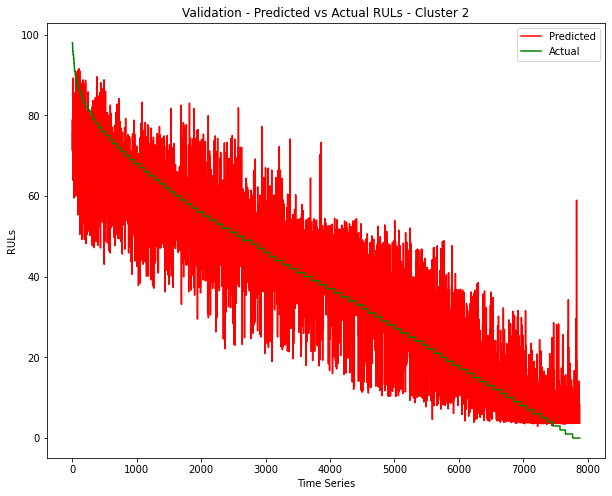


Training


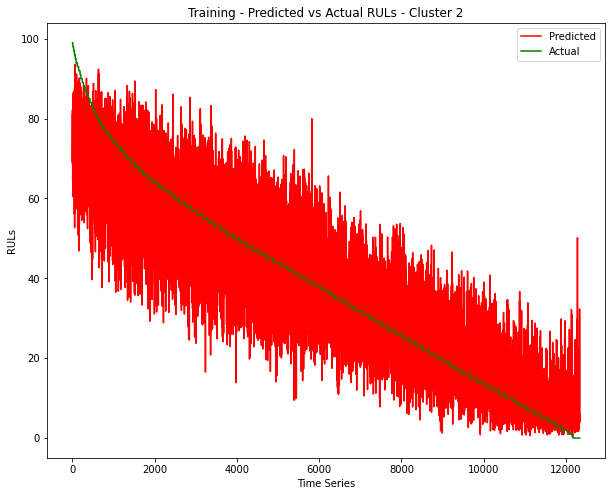

In [ ]:

def print_ruls_predictions(arg="", title="Validation"):
  for i in range(kmeans.n_clusters):
      try:
        # reload the list of cycles
        with open(dumps_path + f'_history_training_models_{i}-{training_session}.pickle', 'rb') as f:
          history = pickle.load(f)

        min_val_loss = min(history["val_loss"])

        # restore the best epoch
        best_index = history["val_loss"].index(min_val_loss)


        # plot predicted and actual RULs of the best epoch
        plt.figure(figsize=(10,8))
        plt.plot(history[f"{arg}rul_predicted"][best_index], color='r', label='Predicted')
        plt.plot(history[f"{arg}ruls_actual"][best_index], color='g', label='Actual')
        plt.xlabel('Time Series')
        plt.ylabel('RULs')
        plt.title(f'{title} - Predicted vs Actual RULs - Cluster {i + 1}')
        plt.legend()
        plt.show()
      except:
        pass

print("Validation")
print_ruls_predictions()
print()
print("Training")
print_ruls_predictions(arg="train_", title="Training")

### PRINT VAL_LOSS AND TRAIN_LOSS

In [ ]:
training_session=6

The following function will plot the training and validation loss of the training, for each cluster.

best epoch loss cluster 2 - training session 6
val loss cluster 4.9416647401557965
training loss 6.001947412688626



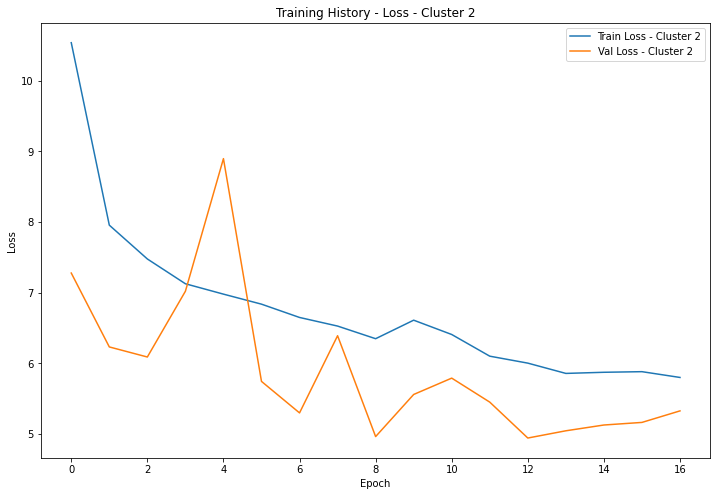

In [ ]:

for i in range(kmeans.n_clusters):
    try:     
        with open(dumps_path + f'_history_training_models_{i}-{training_session}.pickle', 'rb') as f:
          history = pickle.load(f)

        min_val_loss = min(history["val_loss"])
        
        # restore the best epoch
        best_index = history["val_loss"].index(min_val_loss)

        print(f"best epoch loss cluster {i + 1} - training session {training_session}")
        print(f"val loss cluster" , min_val_loss)
        print(f"training loss" , history["train_loss"][best_index])
        print()

        # plot training and validation loss 
        plt.figure(figsize=(12, 8))
        plt.plot(history['train_loss'], label=f'Train Loss - Cluster {i+1}')
        plt.plot(history['val_loss'], label=f'Val Loss - Cluster {i+1}')
        plt.title(f'Training History - Loss - Cluster {i + 1}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    except:
      pass


## LOAD TRAINED MODELS

We can restore, for each cluster, the saved best model.

In [ ]:
restore_training_session = [4,6,5]

models = [RULNet().to(device) for j in range(kmeans.n_clusters)]

for i in range(len(models)):
  state = torch.load(os.path.join(base_path,f'rul_model_cluster_dict-{i}-{restore_training_session[i]}.pth'))
  models[i].load_state_dict(state)

# METRICS

In this section we're going to load testing data, and to print the final metrics for training, validation and testing datasets.

## LOAD TESTING DATA

In [ ]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from joblib import dump, load
import h5py
#dumps_path = '/content/drive/MyDrive/Colab Notebooks/progetto_manutenzione/dumps'
#base_path = '/content/drive/MyDrive/Colab Notebooks/progetto_manutenzione/dataset/'

def extract_df_val(path: str):
  with h5py.File(path, 'r') as hdf:
    ['A_val', 'W_val', 'X_s_val']
    W = np.array(hdf.get('W_val'))            # W
    X_s = np.array(hdf.get('X_s_val'))        # X_s
    A = np.array(hdf.get('A_val'))             # Auxiliary

    W_var = ['alt','Mach','TRA','T2']
    X_s_var = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30','P40', 'P50', 'Nf', 'Nc', 'Wf']  
    A_var = ['unit','cycle','Fc','hs']

    '''
    df_X = pd.DataFrame(X_s, columns=X_s_var)
    df_W = pd.DataFrame(W, columns=W_var)
    df_A = pd.DataFrame(A, columns=A_var)
    '''
    df_X = pd.DataFrame(X_s, columns = X_s_var)
    df_W = pd.DataFrame(W, columns = W_var)
    df_A = pd.DataFrame(A, columns = A_var)
    return pd.concat([df_W, df_A, df_X], axis=1)

We're going to create the Cycle() objects for each flight inside the testing dataset.

Since some time series don't have a stable flight (i.e., empty cruise datasets), we're going to take flights above 10,000 feet, since stable flights are generally at that altitude.

In [ ]:
dfs_test_sep = extract_df_val(path = base_path+'Data_Challenge_2021_N-CMAPSS_DS_Validation_f.h5')

def get_val_cycle_list(dfs_test_sep, filename):
  test_sampling_rate = 1
  #print(len(dfs_test_sep))
  cycle_test_list = [Cycle() for n in range(0, len(dfs_test_sep), test_sampling_rate)]
  for n in tqdm(range(0, len(cycle_test_list))):
    local_cycle = cycle_test_list[n]
    local_cycle.cycle = add_cond_features([dfs_test_sep[n]])[0]
    local_cycle.cruise = filter_cruise_alt(local_cycle.cycle, 30, 2, 60)

    if len(local_cycle.cruise) == 0:
      print()
      non_missing_df = local_cycle.cycle.dropna()
      local_cycle.cruise = non_missing_df[non_missing_df['alt'] >= 10000]
      print("found empty local_cycle.cruise")
      print("taking only flights above 10.000 feets")

    local_cycle.condition = local_cycle.cruise[['alt', 'Mach', 'TRA', 'T2',
                      'alt_diff', 'Mach_diff', 'TRA_diff', 'T2_diff', 'hs', 'cycle']]
    local_cycle.transform_condition(cond_pca, cond_scaler)
    local_cycle.cruise.insert(loc = 0, column='cluster', value=kmeans.predict(local_cycle.condition))
    local_cycle.create_cluster_list(kmeans.n_clusters, train=True)

    # save the list of objects
  with open(dumps_path + filename, 'wb') as f:
      pickle.dump(cycle_test_list, f)
  
  return cycle_test_list

dfs_test_sep = get_cycle_list([dfs_test_sep])
cycle_test_list = get_val_cycle_list(dfs_test_sep, 'cycle_test_list.pickle')

## LOAD CYCLE TEST LIST

We can restore che list of Cycle objects from the storage.

In [ ]:
# reload the list of cycles
with open(dumps_path + 'cycle_test_list.pickle', 'rb') as f:
    cycle_test_list = pickle.load(f)

## PREDICTIONS

For each Cycle object (i.e., each flight), we will predict the RUL of each time series. Since each time series can belong to a specific cluster, we will use the model trained on that specific cluster for prediction. However, since Cluster 1 is the largest, to make one final RUL prediction for each flight, we will use a weighted average of all the predictions, giving more importance to predictions from Cluster 1.

In [ ]:
cluster_weights = [1,1.5,1]

### TRAIN PREDICTIONS

In [ ]:

for i in tqdm (range(len(cycle_list))):
    

    all_list_df = cycle_list[i].cluster_list
    final_scores = []
    weights = []

    
    rg = range(len(all_list_df))

    # get the time series of the cluster j
    for j in rg:

          # this is the list of all time series of the cluster j of the specific cycle
          single_list_df = cycle_list[i].cluster_list[j]

          tensors = []
          targets = []

          cluster = j
          
          # create normalized tensors for prediction
          for single_df in single_list_df:

                  rul = single_df.iloc[0].RUL
                  targets.append(rul)

                  
                  cycle_list[i].rul = rul

                 
                  new_df = single_df.drop(columns=list_drop_columns)
                  str_columns(new_df)
                  new_df = min_max_scalers[cluster].transform(new_df)
           
                  
                  tensor = torch.from_numpy(new_df).float().permute(1,0)
                  tensors.append(tensor)

          # make predictions on tensors using the model trained on cluster j
          if len(tensors) != 0:
            batches = list(create_batches(tensors, targets, batch_size=1, val = True))

            # since we filter time series less than x seconds
            # check if there is at least one batch for evaluation
            if len(batches) > 0:
              _, _,predictions,_= evaluate_model(models[cluster], criterion, batches)

              final_scores += predictions
              weights += [cluster_weights[cluster] for l in range(len(predictions))]

  
    # for the single cycle, create one final RUL as a weighted average of all the predictions
    final_score = (np.average(final_scores, weights = weights))

    # update the prediction
    cycle_list[i].predicted_rul = final_score


100%|██████████| 4484/4484 [03:42<00:00, 20.11it/s]


### VAL PREDICTIONS

In [ ]:

for i in tqdm (range(len(cycle_val_list))):
    

    all_list_df = cycle_val_list[i].cluster_list
    final_scores = []
    weights = []

    
    rg = range(len(all_list_df))

    # get the time series of the cluster j
    for j in rg:

          # this is the list of all time series of the cluster j of the specific cycle
          single_list_df = cycle_val_list[i].cluster_list[j]

          tensors = []
          targets = []

          cluster = j
          
          # create normalized tensors for prediction
          for single_df in single_list_df:

                  rul = single_df.iloc[0].RUL
                  targets.append(rul)

                  
                  cycle_val_list[i].rul = rul

                 
                  new_df = single_df.drop(columns=list_drop_columns)
                  str_columns(new_df)
                  new_df = min_max_scalers[cluster].transform(new_df)
           
                  
                  tensor = torch.from_numpy(new_df).float().permute(1,0)
                  tensors.append(tensor)

          # make predictions on tensors using the model trained on cluster j
          if len(tensors) != 0:
            batches = list(create_batches(tensors, targets, batch_size=1, val = True))

            # since we filter time series less than x seconds
            # check if there is at least one batch for evaluation
            if len(batches) > 0:
              _, _,predictions,_= evaluate_model(models[cluster], criterion, batches)

              final_scores += predictions
              weights += [cluster_weights[cluster] for l in range(len(predictions))]

  
    # for the single cycle, create one final RUL as a weighted average of all the predictions
    final_score = (np.average(final_scores, weights = weights))

    # update the prediction
    cycle_val_list[i].predicted_rul = final_score


100%|██████████| 2908/2908 [02:09<00:00, 22.54it/s]


### TEST PREDICTIONS

In [ ]:

for i in tqdm (range(len(cycle_test_list))):
    

    all_list_df = cycle_test_list[i].cluster_list
    final_scores = []
    weights = []

    
    rg = range(len(all_list_df))

    # get the time series of the cluster j
    for j in rg:

          # this is the list of all time series of the cluster j of the specific cycle
          single_list_df = cycle_test_list[i].cluster_list[j]

          tensors = []
          targets = []

          cluster = j
          
          # create normalized tensors for prediction
          for single_df in single_list_df:
                 
                  new_df = single_df.drop(columns=list_drop_columns)
                  str_columns(new_df)
                  new_df = min_max_scalers[cluster].transform(new_df)
           
                  
                  tensor = torch.from_numpy(new_df).float().permute(1,0)
                  tensors.append(tensor)

          # make predictions on tensors using the model trained on cluster j
          if len(tensors) != 0:
            batches = list(create_batches(tensors, targets, batch_size=1, val = True))

            # since we filter time series less than x seconds
            # check if there is at least one batch for evaluation
            if len(batches) > 0:
              _, _,predictions,_= evaluate_model(models[cluster], criterion, batches)

              final_scores += predictions
              weights += [cluster_weights[cluster] for l in range(len(predictions))]

  
    # for the single cycle, create one final RUL as a weighted average of all the predictions
    final_score = (np.average(final_scores, weights = weights))

    # update the prediction
    cycle_test_list[i].predicted_rul = final_score


#### SAVING RESULTS ON CSV

Save the results of testing dataset to a csv

In [ ]:
pred_ruls = []
for i in range (len(cycle_test_list)):
  pred_ruls.append((cycle_test_list[i].predicted_rul))

predictions = pd.DataFrame(pred_ruls,columns=['predictions'])
predictions.to_csv(os.path.join(base_path, 'final_testing_predictions.csv'),index=False)


## RMSE AND NASA SCORE

For training and validation datasets, we print the value of the defined metrics.

In [ ]:
criterion = challenge_loss

In [ ]:
rmse = RMSE_loss

### VALIDATION

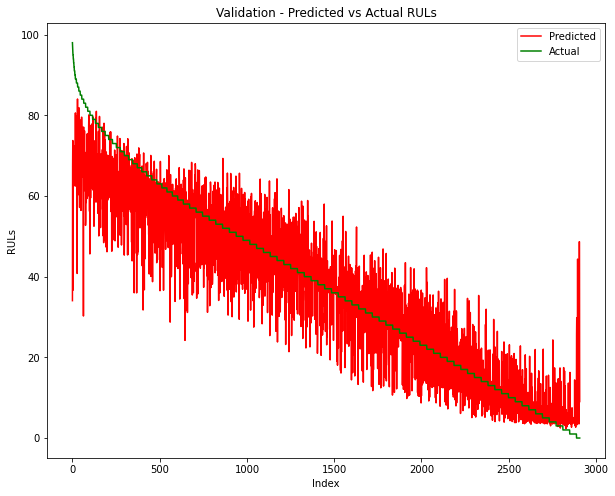


nasa score validation:  5.272708415985107
RMSE validation:  9.294027328491211


In [ ]:
pred_ruls = []
real_ruls = []
for i in range (len(cycle_val_list)):
  real_ruls.append((cycle_val_list[i].rul))
  pred_ruls.append((cycle_val_list[i].predicted_rul))

rul_predicted = [pred_ruls[i] for i in np.argsort(real_ruls)[::-1]]
ruls_actual = np.sort(real_ruls)[::-1]

plt.figure(figsize=(10,8))
plt.plot(rul_predicted, color='r', label='Predicted')
plt.plot(ruls_actual, color='g', label='Actual')
plt.xlabel('Index')
plt.ylabel('RULs')
plt.title('Validation - Predicted vs Actual RULs')
plt.legend()
plt.show()

pred_ruls = torch.tensor(pred_ruls).float().unsqueeze(1)
real_ruls = torch.tensor(real_ruls).float().unsqueeze(1)

print()
print("nasa score validation: ", criterion(pred_ruls, real_ruls).item())
print("RMSE validation: ", rmse(pred_ruls, real_ruls).item())

### TRAINING

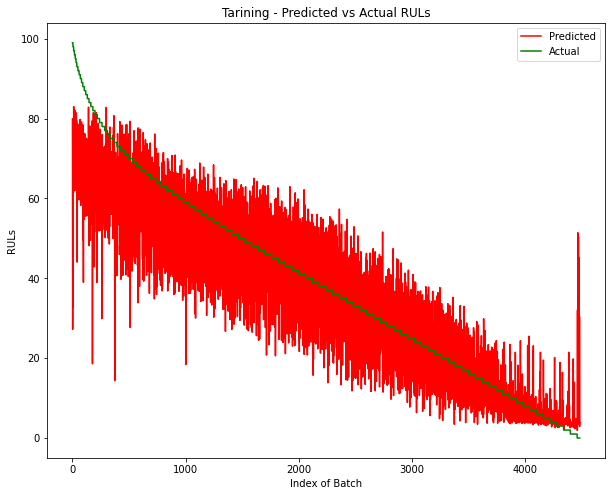


nasa score training:  6.34022331237793
RMSE training:  10.989152908325195


In [ ]:
pred_ruls = []
real_ruls = []
for i in range (len(cycle_list)):
  real_ruls.append((cycle_list[i].rul))
  pred_ruls.append((cycle_list[i].predicted_rul))


rul_predicted = [pred_ruls[i] for i in np.argsort(real_ruls)[::-1]]
ruls_actual = np.sort(real_ruls)[::-1]

plt.figure(figsize=(10,8))
plt.plot(rul_predicted, color='r', label='Predicted')
plt.plot(ruls_actual, color='g', label='Actual')
plt.xlabel('Index of Batch')
plt.ylabel('RULs')
plt.title('Tarining - Predicted vs Actual RULs')
plt.legend()
plt.show()

pred_ruls = torch.tensor(pred_ruls).float().unsqueeze(1)
real_ruls = torch.tensor(real_ruls).float().unsqueeze(1)

print()
print("nasa score training: ", criterion(pred_ruls, real_ruls).item())
print("RMSE training: ", rmse(pred_ruls, real_ruls).item())

